In [1]:
# install library 
# ! pip install mesa

In [2]:
# import dependancies 
import mesa
import numpy as np
import matplotlib.pyplot as plt
import math
import networkx as nx 

In [3]:
print (mesa.__version__)

2.3.0


## Helper function 

In [4]:
def get_distance(pos_1,pos_2):
    """
    Calculate the euclidian distance bw two position
    used in trade.move()
    """
    
    x1,y1 = pos_1
    x2,y2 = pos_2
    dx = x1-x2
    dy = y1-y2
    return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
    '''
    Helper function for model datacolllector for trade price 
    collapse agent price list of lists 
    '''
    
    return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
    """
    find the geometic mean of a list of prices 
    """
    return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
    """
    For agent reporters in data collector 
    
    return agent trade parteners and none for other agnets  
    """
    if type(aget) == Trader:
        return agent.trade_partners
    else:
        return None

## Resource classes -- sugar and spice agent

In [5]:
# Now define sugar and spice agent
class Sugar(mesa.Agent):
    """  
    Sugar : 
    - contains an amount of sugar
    - Grows one amount of sugar at each turn
    """
    
    def __init__(self, unique_id, model,pos, max_sugar):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_sugar # current amount of sugar
        self.max_sugar = max_sugar
        
    # Add step function 
    def step(self):
        """
        Sugar growth function, adds one unit of sugar each step unitill
        max amount 
        """
        self.amount = min([self.max_sugar,self.amount + 1])

In [6]:
class Spice(mesa.Agent):
    """
    spice:
    - contain an amount of spice
    - grows 1 amont of spice at each turn 
    """
    def __init__(self, unique_id, model, pos, max_spice):
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = max_spice # this tell us how much spice at a given time step
        self.max_spice = max_spice # this tells the moset hat canb e at a location
    
    def step(self):
        """
        Spice growth function, adds one unit of spice each step unit 
        max amount
        """
        self.amount = min([self.max_spice,self.amount + 1])

### Trader class 

In [7]:
class Trader(mesa.Agent):
    """
    Trader: 
    - Has a metobolism for sugar and spice 
    - Harvest and traders sugar and spice to survive and thrive
    """
    
    def __init__(self, unique_id, model, pos, moore = False, sugar = 0, 
                 spice=0, metabolism_sugar = 0, metabolism_spice=0,
                vision = 0):
        super().__init__(unique_id, model)
        self.pos = pos 
        self.moore = moore
        self.sugar = sugar
        self.spice = spice
        self.metabolism_sugar = metabolism_sugar
        self.metabolism_spice = metabolism_spice
        self.vision = vision
        self.price = []
        self.trade_partners = []
        
        
    def get_sugar(self,pos):
        """
        used in self.get_sugar_amout()
        used in self.eat()
        """
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Sugar:
                return agent
            return None

    def get_sugar_amount(self,pos):
        """
        used in self.move as part of self.calculate_welfare()
        """
        sugar_patche = self.get_sugar(pos)
        if sugar_patch:
            return sugar_patch.amount
        return 0
    
    def get_spice(self,pos):
        """
        used in self.get_spice_amount()
        used in self.eat()
        """
        this_cell = self.model.grid.get_cell_list_contents(pos)
        for agent in this_cell:
            if type(agent) is Spice:
                return agent
            return None
        
    def get_spice_amount(self,pos):
        """
        used in self.move as part of self.calculate_welfare()
        """
        spice_patche = self.get_spice(pos)
        if spice_patch:
            return spice_patch.amount
        return 0
    
    def get_trader(self,pos):
        """
        helper function used in self.trade_with_neighbors
        
        """
        this_cell = self.model.grid.get_cell(pos)
        for agent in this_cell:
            if isinstance(agent,Trader):
                return agent
        
        
    def is_occupied_by_other(self, pos):
        """
        Helper funtion part 1 of self.move
        """
        if pos == self.pos:
            # agent's position is considered unoccupied and agent can stay there
            return False
        # get contents of each cell in neighborhood 
        this_cell = self.model.grid.get_cell_list_content(pos)
        for a in this_cell:
            # see if occupied by another agent
            if isinstance(a, Trader):
                return True
            return False
        
    def calculate_welfare(self, sugar, spice):
        """
        Helper function 
        
        part 2 self.move()
        self.move()
        """
        # calculate total resource 
        m_total = self.metabolism_sugar + self.metabolism_spice
        
        # cobb-douglas functional form - p 97 on growing
        return sugar**(self.metabolism_sugar/m_total)* spice**(self.metabolism_spice/m_total)
        
    def is_starved(self):
        """
        Helper funcion for self.maybe_die()
        """
        return (self.sugar <=0 ) or (self.spice <=0)
    
    def calculate_MRS(self):
        """
        Helper function for self.trade()
        
        Determine what trader agent is needs and can give up
        """
        return (self.spice/self.metabolism_spice) / (self.sugar/self.metabolism_sugar)
    
    def calculate_sell_spice_amount(price):
        """
        Helper function for self.may_sell_spice() which is called from 
        self.trade()
        """
        if price >=1:
            sugar = 1
            spice = int(price)
        else:
            sugar = int(1/price)
            spice = 1
        return sugar, spice
    
    
    def sell_spice(self, other, sugar, spice):
        """
        Used in self.maybe_sell_spice()
        """
        self.sugar += sugar
        other.sugar -= sugar
        self.spice -= spice
        other.spice += spice 

        
    def maybe_sell_spice(self,other,price,welfare_self,welfare_other):
        """
        Helper function for self.trader()
        """
        
        sugar_exchanged,spice_exchanged = self.calculate_sell_spice_amount(price)
        
        # Assess new sugar and spice amount - what is change did occur 
        self.sugar = self.sugar + sugar_exchanged 
        other_sugar = other.sugar - sugar_exchanged
        self_spice = self.spice - spice_exchanged
        other_spice = other.spice + spice_exchanged
        
        # double check to ensure agents have resounce 
        if ((self_sugar <=0 ) or 
            (other_sugar <=0) or 
            (self_spice <=0) or 
            (other_spice <=0)):
            return False
        
        #Trade criteria #1 - are both agents better off? 
        both_agents_better_off = (
                                (welfare_self < self.calculate_welfare(self_sugar, self_spice)) and
                                (welfare_other < other.calculate_welfare(other_sugar, other_spice))
                            )

        
        # Trade criteria  #2 is their mrs crossing 
        mrs_not_crossing = self.calculate_MRS() > other.calculalte_MRS()
        if not (both_agents_better_off and mrs_not_crossing):
            return False 
        # criteria met, excute trader
        self.sell_spice(other, sugar_exchanged, spice_exchanged)
        
        return True
        
    def trade(self,other):
        """
        Helper funtion used in trader with neighbors 
        """
        # sanity check to verify code is working as excpected 
        assert self.sugar > 0
        assert self.spice > 0
        assert other.sugar > 0 
        assert other.spice > 0
        
        # Calculate marginal of substitution in growing artificial societies p 103
        mrs_self = self.calculate_MRS()
        mrs_other = other.calculate_MRS()
        
        # Calculate each agents welfare
        welfare_self = self.calculate_welfare(self.sugar, self.spice)
        welfare_sugar = other.calculate_welfare(other.sugar,other.spice)
        
        if math.isclose(mrs_self,mrs_other,rel_tol = 1e-02):
            return 
        
        # calculate price 
        p = math.sqrt(mrs_self*mrs_other)
        if mrs_self > mrs_other:
            # self is a sugar buyer, spice seller
            sold = self.maybe_sell_spice (other, price, welfare_self, welfare_other)
            # not trade - criteria not met 
            if not sold:
                return 
            else:
                # self is a spice buyer, sugar seller
                sold = other.maybe_sell_spice(self, price, welfare_other,welfare_self)
                # no trade - criteria not met
                if not sold:
                    return 
                
            # capture the data 
            self.price.append(price)
            self.trade_partners.append(other.unique_id)

            # continue trading 
            self.trade(other)
                
    
##########################################
#                                        #
#             Main Trade functions       #
#                                        #
##########################################
        
    def move(self):
        
        """
        Funtion for trader agent to identify optimal move for each step in 4 parts
        1. indetify all the possible moves 
        2. Determine which move maximize welfare
        3. Find closet best option 
        4. Move
        """
        # 1. Identify all the possible moves
        neighbors = [ i 
                     for i in self.model.grid.net_neighborhood(self.pos, self.moore,True,self.vision) 
                     if not self.is_occupied_by_other(i)]
        
        print(self.pos, neighbors)
        
        # 2. Determine which move maximize welfare
        welfares = [
            self.calculate_welfare(self.sugar + self.get_sugar_amount(pos), self.spice + self.get_spice_amount(pos)) for pos in neighbors ]
        print(welfares)
        
        # 3. Find the closet best option
        # Find the highest welfares in welfares 
        max_welfare = max(welfare)
        
        # get the index of max welfare cells 
        candidate_indices = [i for i in range(len(welfares))
                            is math.isclose(welfares[i], max_welfare,rel_tol = 1e-02) ]
        
        # 4 convert index to positions of those cells 
        candidates = [neighbors[i] for i in candidates_indices]
        
        min_dist = min(get_distance(self.pos) for pos in candidates)
        
        final_candidates = [ pos for pos in candidates 
                           if math.isclose(get_distance(self.pos,pos), min_dist, rel_tot =1e-02)]
        
        self.random.shuffle(final_candidates)
        
        # 4. Move agents 
        self.model.grid.move_agent(self, final_candidates[0])
        
    def eat(self):
        ''' Function for agents to consumer sugara and spice'''
        # get sugar 
        sugar_patch = self.get_sugar(self.pos)
        if sugar_patch:
            self.sugar += sugar_patch.amount
            sugar_patch.amount = 0
        self.sugar -= self.metabolism_sugar
        
        # get spice
        spice_patch = self.get_spice(self.pos)
        if spice_patch:
            self.spice += spice_patch.amount
            spice_patc.amount = 0 
        self.spice -= self.metabolism_spice
        
        print(self.sugar, self.spice)
        
        
    def may_die(self):
        """
        Function to remove Traders who have consumed all their sugar or spice
        """
        if self.is_starved():
            print(self.unique_if, self.model.schedule.get_type_count(Trader))
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            
            
    def trade_with_neighbors(self):
        """
        Funtion for trader agents to decide who to trade with in three parts
        
        1. Identifcy neighbors who can trader
        2. trade (2 session)
        3. collect data 
        """
        
        neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(self, self.moore, False, self.vision) if self.is_occupied_by_other(pos) ]
        
        if len(neighbor_agents) == 0:
            # Trade returns price and trade (who agent traded with)
            return [],[]
        
        # iterate through trader in neighboring cells and trade
        for a in neighbor_agents:
            if a:
                self.trade(a)
        return 

### Model class

## Add more complexities 
* Add upload landscape,  create environment  for trader agents to harvest and trade sugar and spice. 

In [8]:
class SugarscapeG1mt(mesa.Model):
    """
    A model class of manage Sugarscape with traders(G1mt)
    from growing artificial societies by axtell and epstein
    
    """
    
    def __init__(self, width = 50, height = 50, initial_population = 200,
                endowment_min= 25, endowment_max=50, metabolism_min=1,
                metabolism_max=5, vision_min=1, vision_max =5):
        
        
        # Initiate width and height of sugarscape - create landscape
        self.width = width
        self.height = height
        
        # Initiate population attributes 
        self.initial_population = initial_population
        self.endowment_min = endowment_min
        self.endowment_max = endowment_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        
        # Initiate schedule 
        self.schedule = mesa.time.RandomActivationByType(self)
        
        # initiate mesa grid class
        self.grid = mesa.space.MultiGrid(self.width,self.height, torus =False)
        
        # initiate datacollector ####
        self.datacollector = mesa.DataCollector(
                model_reporters = {"Trader": lambda m: m.schedule.get_type_count(Trader),
                "Trade_volume" : lambda m:sum(len(a.trade_partners)
                for a in m.schedule.agents_by_type[Trader].values()),
                "Price": lambda m: geometic_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values]))},
            agent_reporters = {"Trade_Network": lambda a:get_trade(a)}
        )
        
        # Read in landscapae file form the supplmentary material 
        sugar_distribution = np.genfromtxt("sugar-map.txt")
        spice_distribution = np.flip(sugar_distribution, 1)
        
        agent_id = 0 
        for _,(x,y) in self.grid.coord_iter(): # iterate over every grid cell, this is mesa function (method)
            # instantite our agent 
            max_sugar = sugar_distribution[x,y]
            if max_sugar > 0:
                sugar = Sugar(agent_id,self,(x,y),max_sugar)
                self.schedule.add(sugar)
                self.grid.place_agent(sugar, (x,y))
                agent_id += 1
                
        for _,(x,y) in self.grid.coord_iter():
            max_spice = spice_distribution[x,y]
            if max_spice > 0:
                spice = Spice(agent_id, self, (x,y), max_spice)
                self.schedule.add(spice)
                self.grid.place_agent(spice, (x,y))
                agent_id += 1
                
        for i in range(self.initial_population):
            # get agent position 
            x = self.random.randrange(self.width)
            y = self.random.randrange(self.height)
            # see growing artificial socieities p 108 for paramenter initializaiton
            # gave agents initial endowment
            sugar = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))
            spice = int(self.random.uniform(self.endowment_min, self.endowment_max + 1))
            # give agents initial metabolism - how much each agent burn the sugar and spice at every step of the model
            metabolism_sugar = self.random.uniform(self.metabolism_min, self.metabolism_max + 1)
            metabolism_spice = self.random.uniform(self.metabolism_min, self.metabolism_max + 1)
            # give agent vision - 
            vision = int(self.random.uniform(self.vision_min,self.vision_max + 1))
            # create trader 
            trader = Trader ( unique_id,
                            self,     
                            (x,y), 
                           moore = False,
                           sugar= sugar,
                           spice = spice,
                           metabolism_sugar = metabolism_sugar,
                           metabolism_spice = metabolism_spice,
                           vision = vision )

            # place agent
            self.grid.place_agent(trader, (x,y))
            self.schedule.add(trader)
            print(trader.unique_id, trader.pos, trader.sugar, trader.metabolism_spice)
            agent_id += 1
            
        def randomize_traders(self):
            """
            Helper function for self.step()
            
            puts trader in randomize list for step function
            """
            trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
            self.random.shuffle(trader_shuffle)
            
            return trader_shuffle 
            
        def step(self):
            """
            Unique step function that does staged activation of sugar and spice 
            and then randomly activates traders
            """
            
            # Step sugar agents
            for sugar in self.schedule.agents_by_type[Sugar].values():
                sugar.step()
             
            # Step spice agenst 
            for spice in self.schedule.agents_by_type[Spice].values():
                spice.step()
            
            # step trader agents 
            # to account for agent death and removal we need a seperate data strucute to iterate
            trader_shuffle = self.randomize_traders()
            
            for agent in trader_shuffle:
                agent.price = []
                agent.trade = []
                agent.move()
                agent.eat()
                agent.maybe_die()
                
            trader_shuffle = self.randomize_trader()
            
            for agent in trader_shuffle:
                agent.trade_with_neighbors()
                
            self.schedule.steps += 1 # important for data collector to track the number of steps 
            
            # collect model level data 
            self.datacollactor.collect(self)
            
        def run_model(self, step_count =1000):
            for i in range(step_count):
                self.step()
            

``` json

model = SugarscapeG1mt()
model.run_model(step_count = 5)

``` 

## Analyse Data

In [9]:
results = model.datacollector.get_model_vars_dataframe()

NameError: name 'model' is not defined

In [ ]:
results.plot(y="Trader", use_index = True)

In [ ]:
# plot trade price per step

y = list(results["Price"])
x = range(1000)

plt.scatter(x,y,s=1)

In [ ]:
# plot trade volume 

plt.bar(results.index, results["Trade volume"][10:])

In [10]:
# plot trade volume improved 

for i in range(1000):
    plt.vlines(i,0,results['Trade Volume'][i])

NameError: name 'results' is not defined

In [12]:
# Retrieve agent level results 
agent_results = model.datacollector.get_agent_vats_dataframe()

# filter out none from non-trader agents 
agent_results = agent_result[agent_results['Trade_Network'].notnull()]
agent_results

NameError: name 'model' is not defined

In [13]:
for i in range(1000):
    plt.vlines(i,0,result["Trade volume"][i])

NameError: name 'result' is not defined

In [14]:
# Creating network instance 
G = nx.Graph()

# add agent keys to make initial node set 
G.add_nodes_from(list(model.schedule.agent_by_type[Trader].keys()))


# create edge list 
for idx,row in agent_results.iterrows():
    if len(row["Trade Network"]) > 0:
        for agent in row['Trader Network']:
            G.add_edge(idx[i],agent)
    
    

NameError: name 'model' is not defined

In [15]:
nx.model_connectivity(G), nx.average_clustering(G), nx.diameter(G), mx.global_efficiency(G)

AttributeError: module 'networkx' has no attribute 'model_connectivity'

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

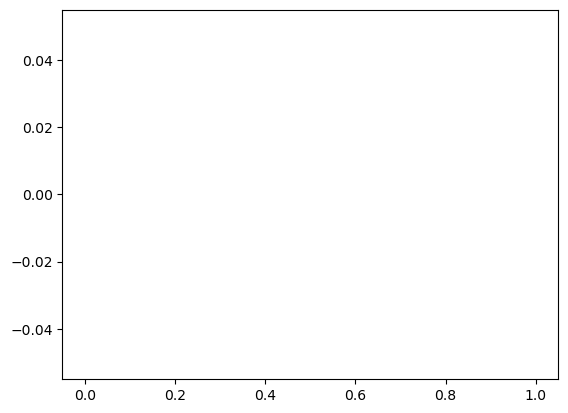

In [17]:
degree = [d for n,d in G.degree()]
plt.hist(degree)

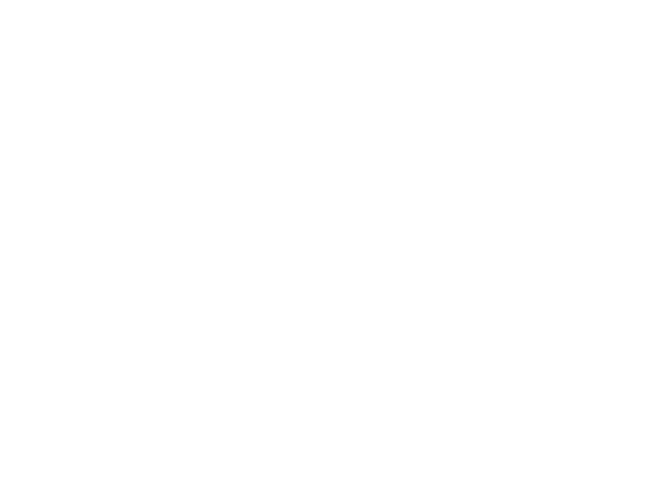

In [18]:
nx.draw(G)

### Batch Run and analysis 

``` json
params = { "width": 50, "height": 50,

"vision_min": range(1,3),

"metabolism_max": [3,5] }

results_batch = mesa.batch_run(
                        SugarscapeG1mt,
                        parameters params,
                        iterations 1,
                        number processes =1,
                 data_collection_period = 1,
                   display_progress = True)

``` 

In [20]:
import pandas as pd
result_df = pd.Dataframe(result_batch)
result_df

AttributeError: module 'pandas' has no attribute 'Dataframe'

``` json
plt.scatter(result_df["Step"], results_df["Price"], s=0.75)

```

In [21]:
results_explore = results_df[results_df["metabolism_max"]==3]
results_explore

NameError: name 'results_df' is not defined

In [22]:
plt.scatter(result_explore["Step"],results_explore["Price"], s=0.75 )

NameError: name 'result_explore' is not defined

In [24]:
for i in range(4):
    results_explore = results_df[results_df["RunId"] == i
                                ]
    plt.plots(result_explore["Step"],results_explore["Trader"])

NameError: name 'results_df' is not defined